In [1]:
#!/usr/bin/env python3
import argparse
from importlib import import_module
from itertools import count
import os

import h5py
import json
import numpy as np
from sklearn.metrics import average_precision_score
import tensorflow as tf

import common
import loss

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.utils.np_utils import to_categorical
from keras.layers import LeakyReLU, Concatenate, concatenate, Lambda, UpSampling2D, Add, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization

In [2]:
class Args:
    excluder= 'market1501' #, 'diagonal','cuhk03','duke'
    query_dataset = '/home/k/kajal/triplet-reid/data/market1501/market1501_query.csv'
    query_embeddings = '/home/k/kajal/triplet-reid/experiments/MARKET/marketoriginal/testing_features/25k/test_embeddings.h5'
    query_embeddings_adv = '/home/k/kajal/triplet-reid/experiments//MARKET/marketrecon255/test_embeddings.h5'
    gallery_dataset = '/home/k/kajal/triplet-reid/data/market1501/market1501_test.csv'
    gallery_embeddings =  '/home/k/kajal/triplet-reid/experiments/MARKET/marketoriginal/testing_features/25k/query_embeddings.h5'
    metric =  'euclidean'
    #filename = 
    batch_size = 18

In [3]:
args=Args()

In [4]:
# Load the query and gallery data from the CSV files.
query_pids, query_fids = common.load_dataset(args.query_dataset, None)
gallery_pids, gallery_fids = common.load_dataset(args.gallery_dataset, None)

# Load the two datasets fully into memory.
with h5py.File(args.query_embeddings, 'r') as f_query:
    query_embs = np.array(f_query['emb'])
    query_embs_dp = np.array(f_query['emb'])
with h5py.File(args.gallery_embeddings, 'r') as f_gallery:
    gallery_embs = np.array(f_gallery['emb'])

In [5]:
gallery_embs=gallery_embs[6618:]
gallery_pids=gallery_pids[6618:]

In [6]:
uni_pids=np.unique(gallery_pids)
print(len(uni_pids))
uni_query_pids=np.unique(query_pids)
len(uni_query_pids)

750


750

In [7]:
print(query_embs.shape)
print(gallery_embs.shape)

(3368, 128)
(13114, 128)


In [8]:
print(query_embs[0],query_embs[1])

[ 4.8578076   0.49806583 -2.1642919   0.21160865  0.4522472   1.4865713
  2.5339327  -2.2136059  -0.49413547 -3.6067448  -0.73834336  2.2198305
  1.59626    -0.24341315 -0.820219   -1.7269121  -0.31842628  2.3572934
 -0.30042982 -2.7999177  -3.0881202  -3.6693394   0.5437899  -2.4301896
 -4.5000668  -4.8148327   0.25089148  3.896863   -3.1136765   1.3295243
  1.7783343  -3.020879   -2.7537892   0.15144461  2.7678092  -1.0873866
 -2.6008525  -2.6290553   3.1873167  -0.2377414   2.2257316  -1.0330088
  0.8257315   0.7888453  -2.4868639   1.9264647   5.35813    -0.994812
 -3.0382683   3.0301461   0.9270819   3.3572843   2.2385774   2.4474237
 -2.2447503   2.1503158   0.63729393  0.8220682  -3.1866279  -0.591922
 -1.3412789  -0.84140223  0.9233606   4.508226    1.0028676  -0.0552148
  3.1772554  -2.3806617  -0.20249811  3.7637513  -0.87892663 -1.0978868
  0.7866139   4.805693   -4.618082    2.190352    0.07782728 -1.3974516
  1.4566518   1.8277098  -3.1526055  -0.16021012  1.7365348   0.44

In [9]:
#query_embs_dp=query_embs
query_embs_dp.shape
query_embs[0]
print(np.min(query_embs),np.mean(query_embs),np.max(query_embs),np.std(query_embs))

-10.587848 -0.05182138 13.120755 2.3269873


In [ ]:
query_embs_dp[0,1]=np.random.normal(0.021068161,2.312213)
query_embs_dp=np.exp(0.7) * query_embs_dp +0.001
print(query_embs[0])
print(query_embs_dp[0])

In [ ]:
def l1(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.max(np.subtract(actual,pred)).mean()

def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.max(np.square(np.subtract(actual,pred)).mean())

D0 = query_embs + np.random.normal(0.021068161,2.312213)
D1 = query_embs_dp + np.random.normal(0.021068161,2.312213)
#print(D0,D1)
#sens1 = l1(query_embs,query_embs_dp)
sens2 = mse(D0,D1)
print(sens2)

In [10]:
query_data = query_pids
query_values = array(query_data)
print('values', query_values)
# integer encode
query_label_encoder = LabelEncoder()
query_integer_encoded = query_label_encoder.fit_transform(query_values)
print('encoded', query_integer_encoded)
# binary encode
query_onehot_encoder = OneHotEncoder(sparse=False)
query_integer_encoded = query_integer_encoded.reshape(len(query_integer_encoded), 1)
query_onehot_encoded = query_onehot_encoder.fit_transform(query_integer_encoded)
print(query_onehot_encoded.shape)

values ['0001' '0001' '0001' ... '1501' '1501' '1501']
encoded [  0   0   0 ... 749 749 749]
(3368, 750)


In [11]:
data = gallery_pids
values = array(data)
print('values', values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print('encoded', integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded.shape)

values ['0001' '0001' '0001' ... '1501' '1501' '1501']
encoded [  0   0   0 ... 749 749 749]
(13114, 750)


In [14]:
X_train  = gallery_embs
Y_train_label = onehot_encoded
X_test = query_embs
Y_test_label = query_onehot_encoded
#print(X_train.size)
#print(X_test.size)
#print(Y_train_label)
#print(Y_test_label)

In [15]:
#print(Y_train_label[2:5000])
#y_train_label = to_categorical(Y_train_label)
#y_train_label.shape

In [16]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add( Dense(units=512, input_dim=128, kernel_initializer='normal', activation='relu') )
model.add( Dropout(0.5))
model.add( Dense(units=750, kernel_initializer='normal', activation='softmax') )
print( model.summary() )
model.compile( loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 750)               384750    
                                                                 
Total params: 450,798
Trainable params: 450,798
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
train_history = model.fit( x=gallery_embs, y=Y_train_label, validation_split=0.2, epochs=5, batch_size=128, verbose=2)

Epoch 1/5
82/82 - 6s - loss: 3.8600 - accuracy: 0.3208 - val_loss: 11.5978 - val_accuracy: 0.0000e+00 - 6s/epoch - 67ms/step
Epoch 2/5
82/82 - 1s - loss: 1.0350 - accuracy: 0.7296 - val_loss: 13.2463 - val_accuracy: 0.0000e+00 - 777ms/epoch - 9ms/step
Epoch 3/5
82/82 - 1s - loss: 0.5768 - accuracy: 0.8346 - val_loss: 14.1162 - val_accuracy: 0.0038 - 1s/epoch - 14ms/step
Epoch 4/5
82/82 - 1s - loss: 0.4013 - accuracy: 0.8853 - val_loss: 14.7465 - val_accuracy: 0.0038 - 722ms/epoch - 9ms/step
Epoch 5/5
82/82 - 1s - loss: 0.3253 - accuracy: 0.9022 - val_loss: 15.3227 - val_accuracy: 0.0038 - 741ms/epoch - 9ms/step


In [18]:
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test_label)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test)
print("predictions shape:", predictions)

Evaluate on test data
106/106 [==============================] - 1s 9ms/step - loss: 3.5556 - accuracy: 0.7325
test loss, test acc: [3.5555636882781982, 0.7324821949005127]
Generate predictions for 3 samples
106/106 [==============================] - 1s 4ms/step
predictions shape: [[9.9972016e-01 4.9103960e-08 5.2692636e-15 ... 2.1290048e-10
  1.7710953e-12 4.3518487e-11]
 [3.4667744e-04 1.1135455e-05 4.1214370e-09 ... 8.4548248e-07
  2.8294227e-09 3.3559013e-07]
 [9.7922611e-01 2.9854311e-07 1.1216707e-13 ... 1.1224925e-09
  4.8283461e-12 4.4735254e-10]
 ...
 [2.2129910e-03 2.7436830e-05 1.2236872e-08 ... 4.3993583e-05
  1.3805845e-07 5.6850522e-06]
 [3.0054912e-04 2.2906203e-05 4.0256779e-08 ... 5.0358642e-05
  1.1637899e-06 9.5914929e-06]
 [1.9948267e-04 3.2654602e-06 2.7302812e-08 ... 1.0959447e-05
  3.1970993e-07 1.5648915e-06]]


In [ ]:
from diffprivlib.models import GaussianNB
clf = GaussianNB(epsilon=1,bounds=(-50e50, 50e50))
clf.fit(X_train, gallery_pids)

In [ ]:
clf.predict(X_test)
print("Test accuracy: %f" % clf.score(X_test, query_pids))

In [11]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y
def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 10
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 200
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)
    

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y
             

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 200...
Mean value of sigma: 11.255098
Iteration 10: error is 11.902957


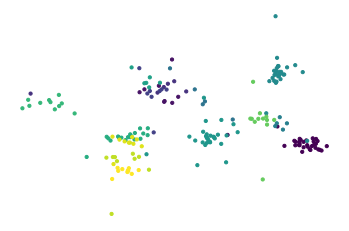

In [22]:
import pylab
X = gallery_embs[100:300]
lbl=list(map(int,gallery_pids))
labels = lbl[100:300]#query_pids[0:20]
pylab.figure()
Y = tsne(X, 2, 50, 20.0)
plt=pylab.scatter(Y[:, 0],Y[:,1],10,labels,marker='o')
pylab.axis('off')
pylab.savefig('rsltn3n1.pdf')
pylab.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test_label)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test)
print("predictions shape:", predictions)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 200...
Mean value of sigma: 13.345691
Iteration 10: error is 13.986041


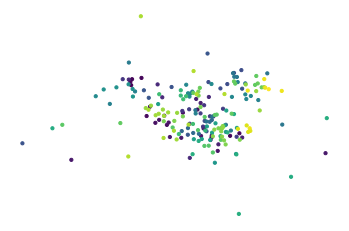

In [20]:
import pylab
X = query_embs[300:500]
lbl=list(map(int,query_pids))
labels = lbl[500:700]#query_pids[0:20]
pylab.figure()
Y = tsne(X, 2, 50, 20.0)
plt=pylab.scatter(Y[:, 0],Y[:,1],10,labels,marker='o')
pylab.axis('off')
pylab.savefig('rsltn3n2.pdf')
pylab.show()

In [ ]:
    #file = query_embs
    #filel = query_pids
    X = query_embs[0:50]
    lbl=list(map(int,query_pids))
    labels = lbl[0:50]#query_pids[0:20]
    print(query_embs,query_pids)
    #X = np.loadtxt("mnist2500_X.txt")
    pylab.figure()
    Y = tsne(X, 2, 50, 20.0)
    plt=pylab.scatter(Y[:, 0],Y[:,1],30,labels,marker='+')
    pylab.axis('off')
    pylab.legend('on')
    pylab.savefig('rsltn3n1.pdf')
    pylab.show()

In [ ]:
    #file = query_embs
    #filel = query_pids
    X = query_embs[0:50]
    lbl=list(map(int,query_pids))
    labels = lbl[0:50]#query_pids[0:20]
    print(query_embs,query_pids)
    #X = np.loadtxt("mnist2500_X.txt")
    pylab.figure()
    Y = tsne(X, 2, 50, 20.0)
    plt=pylab.scatter(Y[:, 0],Y[:,1],30,labels,marker='+')
    pylab.axis('off')
    pylab.legend('on')
    pylab.savefig('rsltn3n1.pdf')
    pylab.show()